# Draft: Exploratory Data Analysis of CORD-19 dataset

!! THIS WORK IS STILL IN PROGRESS !!      
* Basic EDA on CORD-19 dataset using its metadata. 

## Libraries and dependencies 

In [82]:
# !python3 -m pip install wordcloud
# !python3 -m pip install plotly
# !python3 -m pip install nltk
# !python3 -m pip install pandas-profiling
# !python3 -m pip install --upgrade pip
# !python3 -m pip install langdetect

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import time
import warnings 
from pandas_profiling import ProfileReport
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dantohe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some utilities

In [84]:
#adapted from https://www.kaggle.com/paultimothymooney/most-common-words-in-the-cord-19-dataset
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    # adapted from https://stackoverflow.com/questions/36572221/how-to-find-ngram-frequency-of-a-column-in-a-pandas-dataframe
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe['title'].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(dataframe,column,number_of_words):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in dataframe[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(dataframe,column,title):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in dataframe[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

## Loading data for analysis 
Because the data lake version of the data set is very large we are loading a temporarely local stored version of the metadata (created during the step infrastructure setup step).

In [85]:
cord_metadata_raw = pd.read_csv('temp/alleninstitute_metadata_jan_2022.csv')

Number of publications and number of columns describing each paper:

In [86]:
print(f'Current number of papers in the dataset: {cord_metadata_raw.shape[0]}')
print(f'Number of columns describing each paper : {cord_metadata_raw.shape[1]}')

Current number of papers in the dataset: 161564
Number of columns describing each paper : 18


The metadata has the following columns with a distribution of NaN

In [87]:
print(f'\nINFO\n{cord_metadata_raw.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161564 entries, 0 to 161563
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   161564 non-null  int64  
 1   cord_uid                     161564 non-null  object 
 2   sha                          72840 non-null   object 
 3   source_x                     161564 non-null  object 
 4   title                        161514 non-null  object 
 5   doi                          123564 non-null  object 
 6   pmcid                        78160 non-null   object 
 7   pubmed_id                    107809 non-null  float64
 8   license                      161564 non-null  object 
 9   abstract                     119002 non-null  object 
 10  publish_time                 161549 non-null  object 
 11  authors                      155737 non-null  object 
 12  journal                      152546 non-null  object 
 13 

### Empty columns
We noticed that four columns are empty, hence they can be removed:    
'microsoft academic paper id'    
'who #covidence'   
'has_full_text'   
'full_text_file'.

In [88]:
metadata_1 = cord_metadata_raw.copy(deep=True)

In [89]:
metadata_1.pop('microsoft academic paper id')
metadata_1.pop('who #covidence')
metadata_1.pop('has_full_text')
metadata_1.pop('full_text_file')

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
161559   NaN
161560   NaN
161561   NaN
161562   NaN
161563   NaN
Name: full_text_file, Length: 161564, dtype: float64

In [90]:
metadata_1.shape

(161564, 14)

## What magazines have the most number of publications
Picking the top 20 magazines with the largest number of publications:

In [91]:
metadata_1.journal.value_counts()[0:20]

PLoS One                           1757
Journal of virology                1615
bioRxiv                            1598
BMJ                                1471
Lancet                              953
Virology                            939
Surgical endoscopy                  917
Nature                              834
Emerg Infect Dis                    822
Sci Rep                             779
J Med Virol                         749
Viruses                             723
Arch Virol                          670
The Journal of general virology     590
JAMA                                578
Vaccine                             574
Science                             536
Crit Care                           511
Lancet Infect Dis                   503
Virus Res                           467
Name: journal, dtype: int64

Plotting the most representative journals.

<AxesSubplot:>

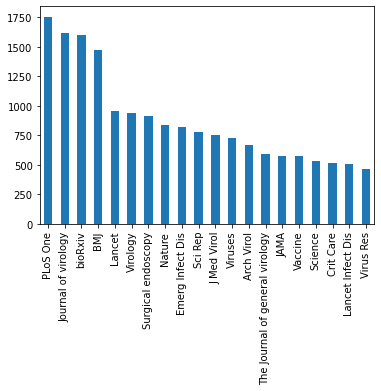

In [92]:
metadata_1.journal.value_counts()[0:20].plot(kind='bar')

## Publication timeline


We noticed that some publication dates are given only as a year (the month and day are missing). This can constitute a problem if we want to investigate precisely the evolution of topics in time.

In [93]:
metadata_1.publish_time.value_counts()[0:30]

2020          27658
2015           3672
2016           3553
2017           3450
2014           3387
2018           2926
2013           2871
2012           2372
2019           2320
2011           2116
2010           1701
2009           1496
2008           1306
2006           1203
2005           1181
2007           1131
2004           1112
2003           1027
2020-06-01      943
2020-05-01      862
2020-05-15      816
2020-05-26      802
2020-05-11      783
2020-05-13      745
2020-05-22      744
2020-04-30      723
2020-05-14      719
2020-04-17      718
2020-05-06      677
2020-06-12      670
Name: publish_time, dtype: int64

Converting publish_time from object to datetime.   


In [94]:
metadata_1.publish_time = pd.to_datetime(metadata.publish_time)
metadata_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161564 entries, 0 to 161563
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    161564 non-null  int64         
 1   cord_uid      161564 non-null  object        
 2   sha           72840 non-null   object        
 3   source_x      161564 non-null  object        
 4   title         161514 non-null  object        
 5   doi           123564 non-null  object        
 6   pmcid         78160 non-null   object        
 7   pubmed_id     107809 non-null  float64       
 8   license       161564 non-null  object        
 9   abstract      119002 non-null  object        
 10  publish_time  161549 non-null  datetime64[ns]
 11  authors       155737 non-null  object        
 12  journal       152546 non-null  object        
 13  url           136477 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage:

After converting publish_time to datetime64 we observe that where only the year or mentioned then the paper was assigned as being published January 1st of that year, so "2020" becomes "2020-0-01". THis can create problems if there is a need to accuratly study the topic trend. 

In [95]:
metadata_1.publish_time.value_counts()[0:10]

2020-01-01    27732
2015-01-01     3696
2016-01-01     3577
2017-01-01     3467
2014-01-01     3408
2018-01-01     2945
2013-01-01     2884
2012-01-01     2385
2019-01-01     2336
2011-01-01     2129
Name: publish_time, dtype: int64

## The most common words
### Most common words in title

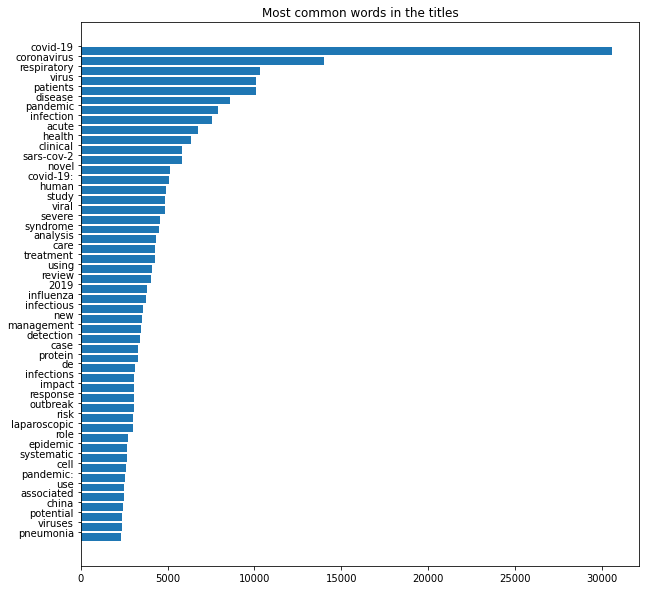

In [96]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata_1,column='title', title='Most common words in the titles')

### The most common words in abstracts

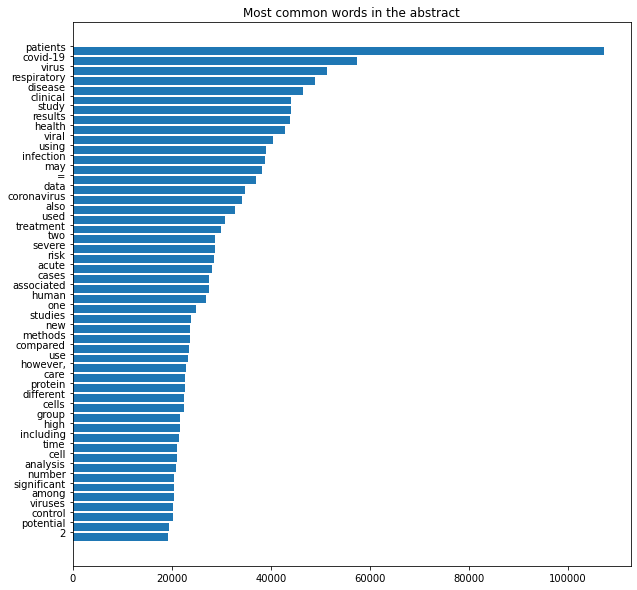

In [97]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata_1,column='abstract', title='Most common words in the abstract')

## Using word cloud 
### Most common word in the title

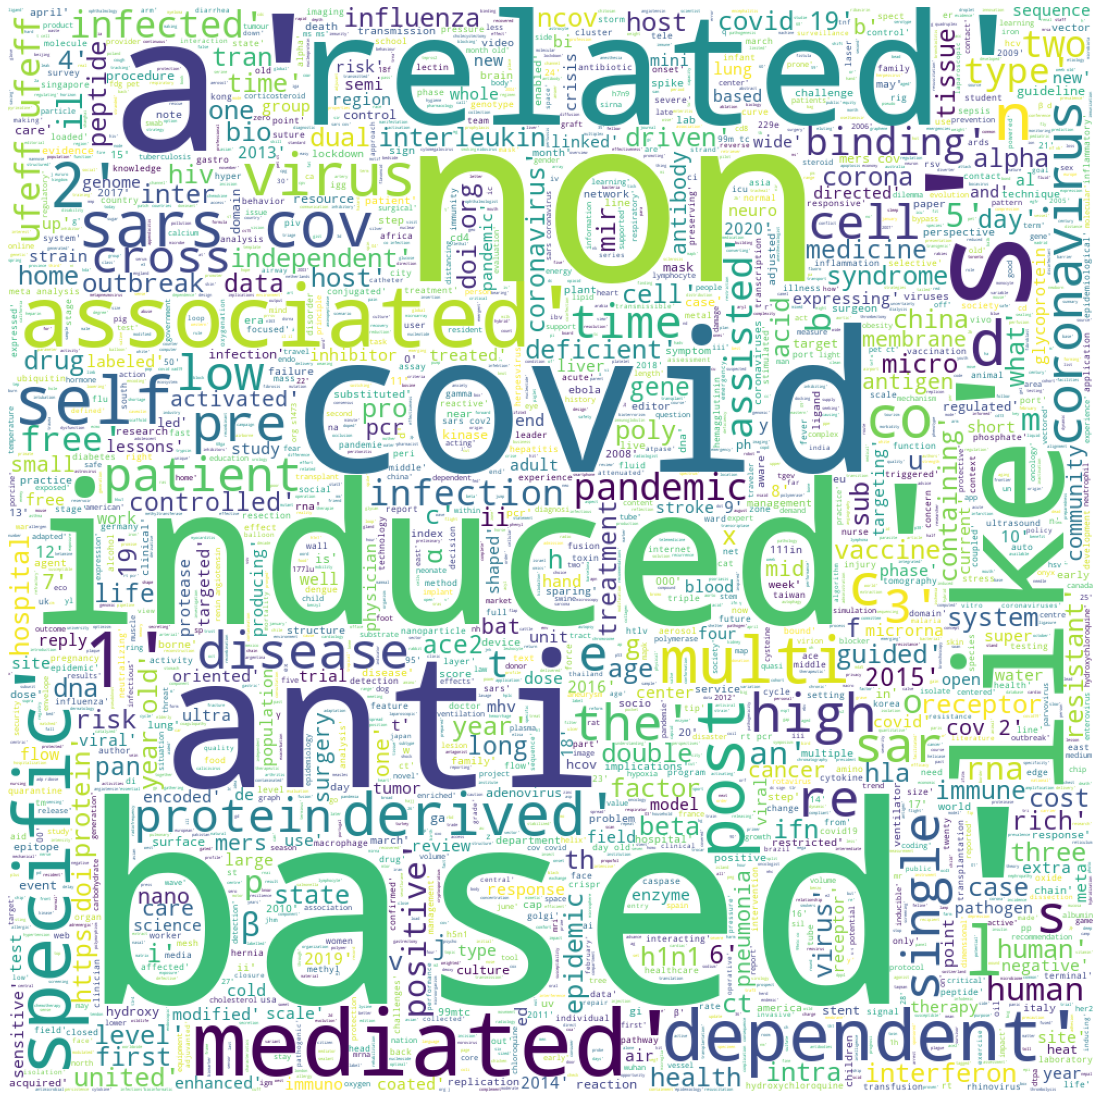

In [98]:
plt.figure(figsize=(20,20))
word_cloud_function(metadata_1,'title',50000)

### Most common word in abstracts 

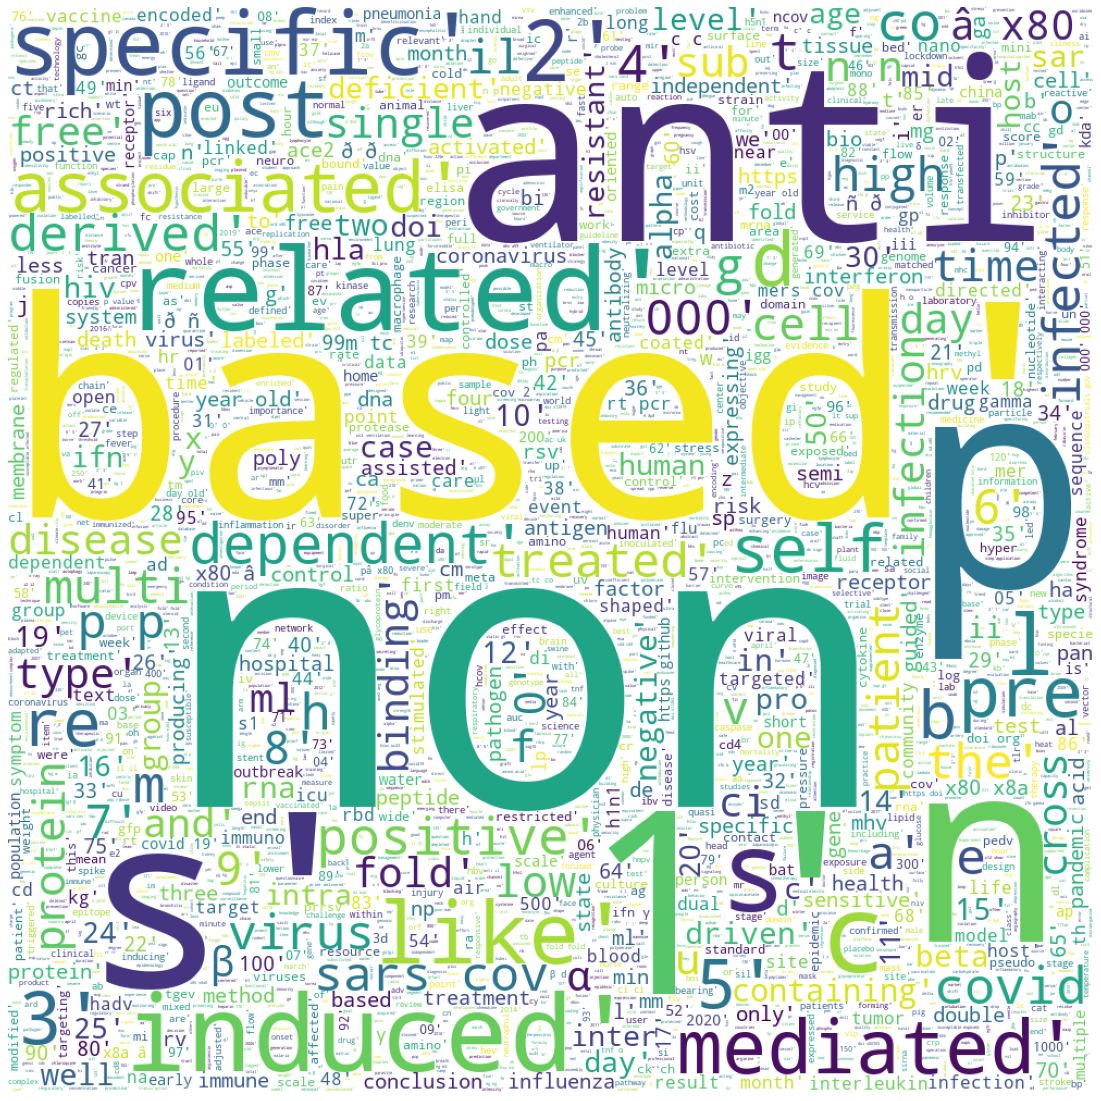

In [99]:
plt.figure(figsize=(20,20))
word_cloud_function(metadata_1,'abstract',50000)

## N-grams
Looking into 3-grams and 2-grams and also storing them for future anlysis    
### 3-Gram


In [ ]:
three_gram = count_ngrams(metadata_1,'title',3,3)

In [101]:
three_gram[0:20]

,frequency,ngram
the covid 19,8250,the covid 19
covid 19 pandemic,7962,covid 19 pandemic
of covid 19,7462,of covid 19
during the covid,3777,during the covid
coronavirus disease 2019,2970,coronavirus disease 2019
covid 19 in,2741,covid 19 in
in covid 19,2671,in covid 19
severe acute respiratory,2592,severe acute respiratory
with covid 19,2489,with covid 19
acute respiratory syndrome,2441,acute respiratory syndrome


## 2-Grams   

In [ ]:
bi_gram = count_ngrams(metadata_1,'title',2,2)

In [100]:
bi_gram[0:20]

,frequency,ngram
covid 19,45184,covid 19
of the,12568,of the
in the,11486,in the
sars cov,8563,sars cov
the covid,8361,the covid
19 pandemic,7994,19 pandemic
of covid,7521,of covid
during the,5620,during the
patients with,5575,patients with
for the,4041,for the


Save bi-gram and three-gram as their computation is intensive.

In [102]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
bi_gram.to_csv('temp/bi_gram.zip', index=True,
          compression=compression_opts)  
three_gram.to_csv('temp/three_gram.zip', index=True,
          compression=compression_opts)  

## Indetifying papers based on some key words
Identify papers with 'vaccine' in their title     
Adapted from: https://www.kaggle.com/docxian/cord-19-metadata-evaluation

In [103]:
#utility 
def word_finder(i_word, i_text):
    found = str(i_text).find(i_word)
    if found == -1:
        result = 0
    else:
        result = 1
    return result

def get_articles_with_keyword(keyword):
    # partial function for mapping
    word_indicator_partial = lambda text: word_finder(keyword, text)
    # build indicator vector (0/1) of hits
    keyword_indicator = np.asarray(list(map(word_indicator_partial, metadata.title)))
    # number of hits
    print(f'Number of hits for keyword {keyword} : ', keyword_indicator.sum())
    # add index vector as additional column
    metadata_1['selection'] = keyword_indicator
    # select only hits from data frame
    articles = metadata_1[metadata_1['selection']==1]
    return articles

In [104]:
vaccine_articles = get_articles_with_keyword('vaccine')
hauler_articles = get_articles_with_keyword('treatment')


Number of hits for keyword vaccine :  1873
Number of hits for keyword treatment :  3369


In [105]:
vaccine_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 242 to 161534
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    1873 non-null   int64         
 1   cord_uid      1873 non-null   object        
 2   sha           1059 non-null   object        
 3   source_x      1873 non-null   object        
 4   title         1873 non-null   object        
 5   doi           1547 non-null   object        
 6   pmcid         1184 non-null   object        
 7   pubmed_id     1457 non-null   float64       
 8   license       1873 non-null   object        
 9   abstract      1522 non-null   object        
 10  publish_time  1873 non-null   datetime64[ns]
 11  authors       1739 non-null   object        
 12  journal       1839 non-null   object        
 13  url           1736 non-null   object        
 14  selection     1873 non-null   int64         
dtypes: datetime64[ns](1), float64(1), 

## Publications Languages
Some of the papers might be in diffrent languages - we need to identify the languages distribution and eliminate the ones that are not in english (there is the option to translate them but that's a diffrent matter).  
The first step is converting to string some of the dataframe columns.

In [106]:
metadata_2 = metadata_1.copy(deep=True)
print(metadata_2.info())
metadata_2[["cord_uid", "sha","source_x","title","abstract","authors","journal"]] = metadata_2[["cord_uid", "sha","source_x","title","abstract","authors","journal"]].astype(str) 
print(metadata_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161564 entries, 0 to 161563
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    161564 non-null  int64         
 1   cord_uid      161564 non-null  object        
 2   sha           72840 non-null   object        
 3   source_x      161564 non-null  object        
 4   title         161514 non-null  object        
 5   doi           123564 non-null  object        
 6   pmcid         78160 non-null   object        
 7   pubmed_id     107809 non-null  float64       
 8   license       161564 non-null  object        
 9   abstract      119002 non-null  object        
 10  publish_time  161549 non-null  datetime64[ns]
 11  authors       155737 non-null  object        
 12  journal       152546 non-null  object        
 13  url           136477 non-null  object        
 14  selection     161564 non-null  int64         
dtypes: datetime64[ns]

Identify languages based on the abstract or the title.

In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 3

# hold label - language
languages_in_abstratcs = []

# go through each text
for x in tqdm(range(0, len(metadata_2))):
    # split by space into list, take the first x intex, join with space
    abstract = metadata_2.iloc[x]['abstract'].split(" ")

    language = "en"
    try:
        if len(abstract) > 50:
            language = detect(" ".join(abstract[:50]))
        elif len(abstract) > 0:
            language = detect(" ".join(abstract[:len(abstract)]))

    except Exception as e:
        all_words = set(abstract)
        try:
            language = detect(" ".join(all_words))
        # finding the title text
        except Exception as e:
            try:
                language = detect(metadata_2.iloc[x]['title'])
            except Exception as e:
                language = "unknown"
                pass

    # get the language
    languages_in_abstratcs.append(language)

Analyze languages

In [75]:
from pprint import pprint

languages_dict = {}
for lang in set(languages_in_abstratcs):
    languages_dict[lang] = languages_in_abstratcs.count(lang)
    
print("Total: {}\n".format(len(languages_in_abstratcs)))
pprint(languages_dict)

Total: 161564

{'af': 2,
 'ca': 11,
 'cy': 3,
 'de': 515,
 'en': 117578,
 'es': 240,
 'et': 2,
 'fi': 1,
 'fr': 260,
 'hr': 1,
 'hu': 15,
 'it': 55,
 'ja': 3,
 'ko': 1,
 'lt': 1,
 'nl': 195,
 'no': 1,
 'pt': 33,
 'ro': 9,
 'ru': 1,
 'tl': 42564,
 'tr': 2,
 'zh-cn': 71}


Visualize the distribution

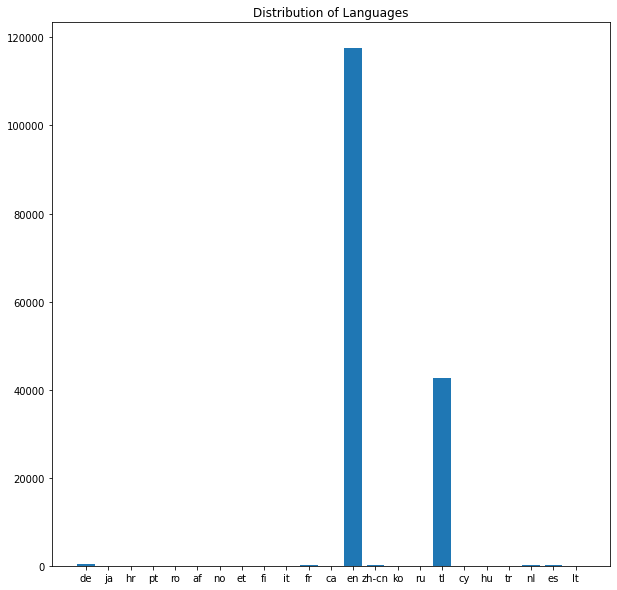

In [77]:
metadata_2['language'] = languages_in_abstratcs
plt.figure(figsize=(10,10))
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages")
plt.show()

We will eliminate non english languages.

In [81]:
print(metadata_2.shape)
metadata_2 = metadata_2[metadata_2['language'] == 'en'] 
print(metadata_2.shape)

(161564, 16)
(117578, 16)


Saving the dataframe containing the english article.

In [107]:
metadata_2.to_csv('temp/metadata_2_language_en.zip', index=True,
          compression=compression_opts)  